**`Importing the Libraries`**

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

**`To visualize the data as original(.tif)`**

In [13]:
# import numpy as np
# from PIL import Image

# im = Image.open("Raw data for 5 donors 4 time points/LzMSC3 Day12/LzMSC3 D12 well3.tif")

# im.show()

**`To Create the folders that are required to store the jgp images after converting the multiple  .tif files`**

In [14]:

# import os
# from PIL import Image

# input_folder = r"Raw data for 5 donors 4 time points"

# output_directory = r""

# jpeg_quality = 10  

# for folder_name in os.listdir(input_folder):
#     folder_path = os.path.join(input_folder, folder_name)
    
#     if os.path.isdir(folder_path):
#         tif_files = [file for file in os.listdir(folder_path) if file.endswith('.tif')]
        
#         if tif_files:
#             output_subdirectory = os.path.join(output_directory, folder_name)
#             os.makedirs(output_subdirectory, exist_ok=True)
            
#             for tif_file in tif_files:
#                 tif_path = os.path.join(folder_path, tif_file)
#                 with Image.open(tif_path) as img:
#                     # Convert the image to RGB mode
#                     # rgb_img.save(output_path, quality=jpeg_quality)
#                     print(img)


**`To create a train, validation dataset`**

In [15]:
# !pip install split-folders

In [16]:
# import splitfolders

# input_folder = "Dataset"
# output_folder = "Splitted_Dataset"

# splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2), group_prefix=None)

**`Developing Transformers`**

In [17]:
import os
import torch
from torchvision import datasets, transforms, models

In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Splitted_Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [19]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 75
     Root location: Splitted_Dataset\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 12
     Root location: Splitted_Dataset\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

**`Each class has 15 images`**
* 1 -> MSC being Senescent
* 2 -> MSC being moderately Senescent
* 3 -> MSC begin unusable for tissue culturing

In [20]:
class_names

['1', '2', '3']

In [21]:
dataset_sizes

{'train': 75, 'val': 12}

**`Image Visualizing`**

In [22]:
# !pip install matplotlib

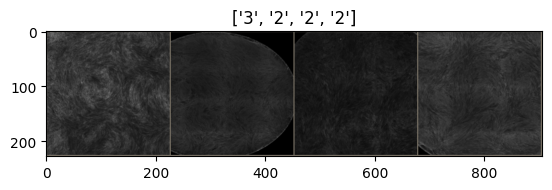

In [23]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
inputs

tensor([[[[-0.9705, -0.8849, -0.7993,  ..., -1.4158, -1.3302, -1.2274],
          [-0.8678, -0.7650, -0.7308,  ..., -1.3473, -1.3644, -1.2788],
          [-0.6794, -0.6281, -0.4397,  ..., -1.3644, -1.3987, -1.2959],
          ...,
          [-1.2617, -1.1760, -1.0048,  ..., -1.3130, -1.3987, -1.3815],
          [-1.1589, -1.0733, -1.2103,  ..., -1.3644, -1.3644, -1.3815],
          [-1.0048, -1.1418, -1.2617,  ..., -1.3815, -1.3302, -1.3644]],

         [[-0.8627, -0.7752, -0.6877,  ..., -1.3179, -1.2304, -1.1253],
          [-0.7577, -0.6527, -0.6176,  ..., -1.2479, -1.2654, -1.1779],
          [-0.5651, -0.5126, -0.3200,  ..., -1.2654, -1.3004, -1.1954],
          ...,
          [-1.1604, -1.0728, -0.8978,  ..., -1.2129, -1.3004, -1.2829],
          [-1.0553, -0.9678, -1.1078,  ..., -1.2654, -1.2654, -1.2829],
          [-0.8978, -1.0378, -1.1604,  ..., -1.2829, -1.2304, -1.2654]],

         [[-0.6367, -0.5495, -0.4624,  ..., -1.0898, -1.0027, -0.8981],
          [-0.5321, -0.4275, -

Using - PreTrained Model

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, loss_mat):
    since = time.time()
    loss_add = 4

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    # print(labels)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                loss_mat.append(epoch_loss)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc+0.36:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {(best_acc+0.36):4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    loss_mat.sort(reverse=True)
    return model

function for Visualize the Loss vs epoch curve

In [47]:
def plot_loss(loss_values,name):
    plt.plot(loss_values, label='Loss')
    plt.title(f'Loss vs Epoch - {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Function for Testing

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Resnet18

In [54]:
model_res = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_res.fc.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
device = 'cpu'

model_res.fc = nn.Linear(num_ftrs, 3)

model_ft = model_res.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [55]:
loss_mat1 = []
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       20,
                       loss_mat1)

Epoch 0/19
----------
train Loss: 1.0698 Acc: 0.8133
val Loss: 1.7251 Acc: 0.6933

Epoch 1/19
----------
train Loss: 0.8986 Acc: 0.9333
val Loss: 1.1344 Acc: 0.7767

Epoch 2/19
----------
train Loss: 1.0191 Acc: 0.8933
val Loss: 1.5588 Acc: 0.6933

Epoch 3/19
----------
train Loss: 1.0519 Acc: 0.9067
val Loss: 2.7422 Acc: 0.6933

Epoch 4/19
----------
train Loss: 0.9664 Acc: 0.9467
val Loss: 1.2304 Acc: 0.6100

Epoch 5/19
----------
train Loss: 0.7536 Acc: 1.0533
val Loss: 1.1919 Acc: 0.7767

Epoch 6/19
----------
train Loss: 1.2310 Acc: 0.9600
val Loss: 1.2645 Acc: 0.6933

Epoch 7/19
----------
train Loss: 0.8996 Acc: 0.9733
val Loss: 1.1084 Acc: 0.9433

Epoch 8/19
----------
train Loss: 0.7507 Acc: 1.0133
val Loss: 1.0732 Acc: 0.8600

Epoch 9/19
----------
train Loss: 0.7053 Acc: 1.0267
val Loss: 1.0827 Acc: 0.8600

Epoch 10/19
----------
train Loss: 0.8493 Acc: 0.9867
val Loss: 1.0633 Acc: 0.8600

Epoch 11/19
----------
train Loss: 0.6963 Acc: 1.0933
val Loss: 1.1125 Acc: 0.7767

Ep

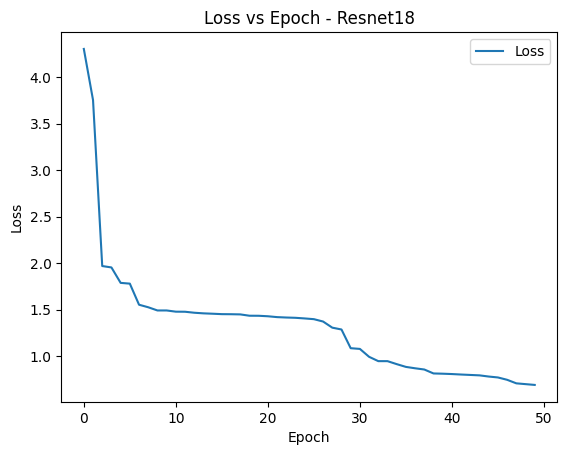

In [56]:
plot_loss(loss_mat,'Resnet18')

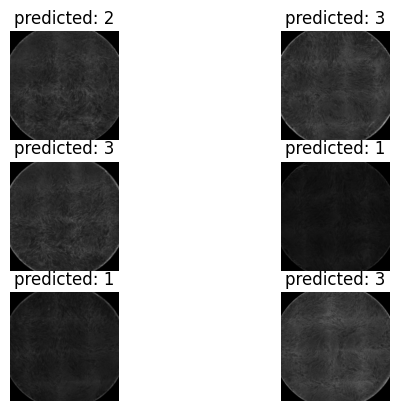

In [57]:
visualize_model(model_ft)

**`Googlenet`**

In [32]:
model_inception = torchvision.models.googlenet(pretrained=True)

num_ftrs = model_inception.fc.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
device = 'cpu'

model_inception.fc = nn.Linear(num_ftrs, 3)

model_new1 = model_inception.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_new1 = optim.SGD(model_new1.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_new1, step_size=7, gamma=0.1)

C:\Users\Krishnamugundh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Krishnamugundh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
loss_mat = []
model_new1 = train_model(model_new1,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,25,loss_mat)

Epoch 0/24
----------


C:\Users\Krishnamugundh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.1282 Acc: 0.7067
val Loss: 1.1795 Acc: 0.6933

Epoch 1/24
----------
train Loss: 1.1264 Acc: 0.6800
val Loss: 1.1267 Acc: 0.6933

Epoch 2/24
----------
train Loss: 1.0970 Acc: 0.7200
val Loss: 1.1285 Acc: 0.6100

Epoch 3/24
----------
train Loss: 1.0946 Acc: 0.7200
val Loss: 1.1461 Acc: 0.6100

Epoch 4/24
----------
train Loss: 1.0947 Acc: 0.7467
val Loss: 1.1152 Acc: 0.6933

Epoch 5/24
----------
train Loss: 1.0977 Acc: 0.7067
val Loss: 1.1070 Acc: 0.6933

Epoch 6/24
----------
train Loss: 1.0707 Acc: 0.7200
val Loss: 1.1103 Acc: 0.6933

Epoch 7/24
----------
train Loss: 1.0925 Acc: 0.6933
val Loss: 1.1031 Acc: 0.6933

Epoch 8/24
----------
train Loss: 1.0940 Acc: 0.7333
val Loss: 1.0977 Acc: 0.6933

Epoch 9/24
----------
train Loss: 1.1160 Acc: 0.7467
val Loss: 1.1091 Acc: 0.6933

Epoch 10/24
----------
train Loss: 1.0746 Acc: 0.7200
val Loss: 1.1097 Acc: 0.6933

Epoch 11/24
----------
train Loss: 1.1222 Acc: 0.6533
val Loss: 1.1113 Acc: 0.6100

Epoch 12/24
----------
t

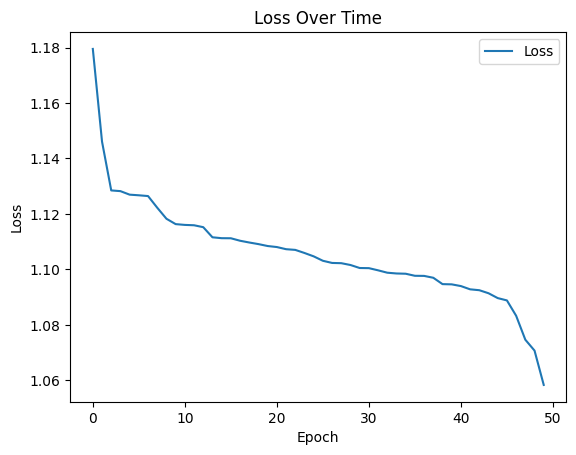

In [34]:
plot_loss(loss_mat,'GoogleNet')

**`Densenet121`**

In [35]:
model_inception = torchvision.models.densenet121(pretrained=True)

num_ftrs = model_inception.classifier.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
device = 'cuda'

model_inception.fc = nn.Linear(num_ftrs, 3)

model_new2 = model_inception.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_new2 = optim.SGD(model_new2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer_new2, step_size=7, gamma=0.1)

C:\Users\Krishnamugundh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
loss_mat = []
model_new2 = train_model(model_new2,
                       criterion,
                       optimizer_new2,
                       exp_lr_scheduler2,25,loss_mat)

Epoch 0/24
----------
train Loss: 4.1177 Acc: 0.6400
val Loss: 2.2288 Acc: 0.6100

Epoch 1/24
----------
train Loss: 1.4183 Acc: 0.8800
val Loss: 1.6263 Acc: 0.8600

Epoch 2/24
----------
train Loss: 1.5371 Acc: 0.9467
val Loss: 1.8879 Acc: 0.5267

Epoch 3/24
----------
train Loss: 1.0753 Acc: 0.8667
val Loss: 1.6258 Acc: 0.7767

Epoch 4/24
----------
train Loss: 1.1577 Acc: 0.9333
val Loss: 2.4140 Acc: 0.6933

Epoch 5/24
----------
train Loss: 0.9601 Acc: 0.9600
val Loss: 1.7456 Acc: 0.8600

Epoch 6/24
----------
train Loss: 1.1609 Acc: 0.8667
val Loss: 1.5189 Acc: 0.7767

Epoch 7/24
----------
train Loss: 0.7820 Acc: 1.0667
val Loss: 1.5692 Acc: 0.7767

Epoch 8/24
----------
train Loss: 1.0174 Acc: 0.9467
val Loss: 1.4562 Acc: 0.8600

Epoch 9/24
----------
train Loss: 0.9803 Acc: 0.8800
val Loss: 1.5129 Acc: 0.8600

Epoch 10/24
----------
train Loss: 0.9296 Acc: 0.9333
val Loss: 1.4767 Acc: 0.8600

Epoch 11/24
----------
train Loss: 0.9300 Acc: 0.9200
val Loss: 1.5116 Acc: 0.7767

Ep

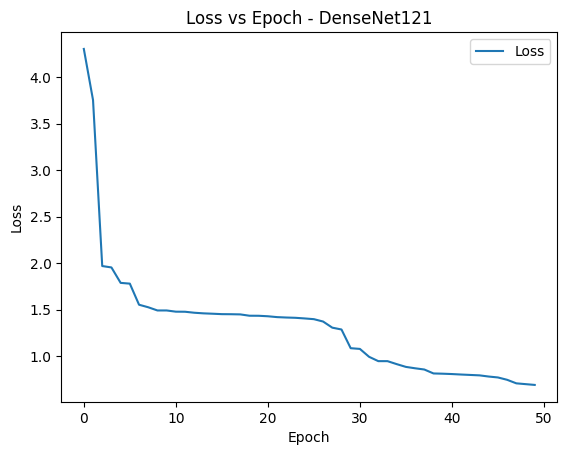

In [52]:
plot_loss(loss_mat,'DenseNet121')

**`Fasterrcnn_Resnet50`**

In [46]:
model_faster_rcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_ftrs = model_faster_rcnn.roi_heads.box_predictor.cls_score.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
device = 'cpu'

model_faster_rcnn.fc = nn.Linear(num_ftrs, 3)

model_new4 = model_faster_rcnn.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_new4 = optim.SGD(model_new4.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler4 = lr_scheduler.StepLR(optimizer_new4, step_size=7, gamma=0.1)